# Measuring Word Similarity with BERT (English Language Public Domain Poems)

By [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We can explore all of these questions with BERT, a natural language processing model that has revolutionized the field.

BERT turns words or tokens into vectors — essentially, a list of numbers in a coordinate system (x, y). We can then use the geometric similarity between these resulting vectors as a way to represent varying types of similarity between words.

## In This Notebook
In this Colab notebook, we will specifically analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) and the HuggingFace Python library. DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

We hope this notebook will help illustrate how BERT works, how well it works, and how you might use BERT to explore the similarity of words in a collection of texts. It is surprising, for example, that BERT works as well as it does, without any fine-tuning, on poems that were published hundreds of years before the text data it was trained on (Wikiepdia pages and self-published novels). 

But we also hope that these results will expose some of the limitations and challenges of BERT. We have to disregard poetic line breaks, for example, and we see that BERT has trouble with antiquated words like "thine," which don't show up in its contemporary vocabulary.

In [ ]:
#@title BERT Word Vectors: A Preview { display-mode: "form" }
#@title: Hover
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

The plot above displays a preview of our later results. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [ ]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web. 
You can find the data in our [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

Below we will use the Python library `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web.

To be clear, however, knowledge of `pandas` is not necessary to use BERT. This is simply how we've chosen to load our data. All you really need  is a list of texts (poems, passages, etc.). You can create this list however you are most comfortable.

In [ ]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
24663,Thomas Hardy,An Experience,"Wit, weight, or wealth there was not\r\nIn anything that was said,\r\nIn anything that was done;\r\nAll was of scope to cause not\r\nA triumph, dazzle, or dread\r\nTo even the subtlest one,\r\nMy ...",2 June 1840-11 January 1928,1840.0,1928.0,http://public-domain-poetry.com/thomas-hardy/an-experience-17186,19th Century
13641,John Milton,The Passion,"I\n\r\nEre-while of Musick, and Ethereal mirth,\r\nWherwith the stage of Ayr and Earth did ring,\r\nAnd joyous news of heav'nly Infants birth,\r\nMy muse with Angels did divide to sing;\r\nBut hea...","December 9, 1608-November 8, 1674",1608.0,1674.0,http://public-domain-poetry.com/john-milton/passion-8327,16th-17th Centuries (Early Modern)
9191,Gilbert Keith Chesterton,The Holy Of Holies,"'Elder father, though thine eyes\r\nShine with hoary mysteries,\r\nCanst thou tell what in the heart\r\nOf a cowslip blossom lies?\n\r\n'Smaller than all lives that be,\r\nSecret as the deepest se...","May 29, 1874-June 14, 1936",1874.0,1936.0,http://public-domain-poetry.com/gilbert-keith-chesterton/holy-of-holies-12144,20th Century
22850,Rudyard Kipling,Contradictions,"The drowsy carrier sways\r\n To the drowsy horses' tramp.\r\nHis axles winnow the sprays\r\nOf the hedge where the rabbit plays\r\n In the light of his single lamp.\n\r\nHe hears a roar behind,\r\...","December 30, 1865-January 18, 1936",1865.0,1936.0,http://public-domain-poetry.com/rudyard-kipling/contradictions-3171,19th Century
3075,Bert Leston Taylor,Post-Impressionism,"\r\nI cannot tell you how I love\r\nThe canvases of Mr. Dove,\r\nWhich Saturday I went to see\r\nIn Mr. Thurber's gallery.\n\r\nAt first you fancy they are built\r\nAs patterns for a crazy quilt,\...","November 13, 1866-March 19, 1921",1866.0,1921.0,http://public-domain-poetry.com/bert-leston-taylor/post-impressionism-39164,19th Century


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

df_taming = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/honors thesis/punctuation/taming/df_tamingoftheshrew_sentence_withactbreakdown.csv')
df_tamertamed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/honors thesis/punctuation/df_tamertamedwithpunctuation.csv')

In [ ]:
for index, row in df_taming.iterrows():
  df_taming['title'] = 'The Taming of the Shrew'
 
for index, row in df_tamertamed.iterrows():
 df_tamertamed['title'] = 'Tamer Tamed'

In [ ]:
#@title *Click here to see how you might load a dataset from your own computer*
#from google.colab import files
#uploaded = files.upload()

Let's check to see how many poems are in this dataset:

In [ ]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [ ]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

In [ ]:
df = pd.concat([df_taming,df_tamertamed])

In [ ]:
df['sentence']

0                                                                                                                                          Enter Beggar ( Christopher Sly ) and Hostess 
1                                                                                                                                                             I’ll feeze you , in faith 
2                                                                                                                                                          A pair of stocks , you rogue 
3                                                                                                                                                                      You’re a baggage 
4                                                                                                                                                                The Slys are no rogues 
                                                                           

Let's check to see what time periods show up the most in this dataset to get a sense of its contours:

<AxesSubplot:>

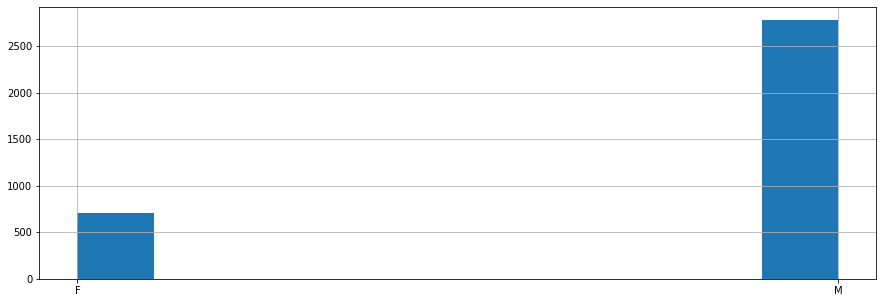

In [ ]:
# Sort values, then create a histogram, and define the size of the figure
df['speaker_gender'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [ ]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [ ]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [ ]:
df = pd.concat([df_taming,df_tamertamed])

In [ ]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
18th Century                          1000
20th Century                          1000
19th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [ ]:
drama_texts_tamer = df_tamertamed['sentence'].tolist()
drama_texts_taming = df_taming['sentence'].tolist()

Let's examine a poem in our dataset:

In [ ]:
len(drama_texts_tamer)

1726

In [ ]:
len(drama_texts_taming)

2349

In [ ]:
#print(drama_texts[0])

## **Encode/tokenize text data for BERT**

Next we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *encoding* or *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenized_poems_tamer = tokenizer(drama_texts_tamer, truncation=True, padding=True, return_tensors="pt")
tokenized_poems_taming = tokenizer(drama_texts_tamer, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [ ]:
' '.join(tokenized_poems_tamer[0].tokens)
' '.join(tokenized_poems_taming[0].tokens)

'[CLS] enter mor ##oso , so ##ph ##oc ##les , and tran ##io , with rosemary , as from a wedding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [ ]:
from transformers import DistilBertModel

In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a `for` loop.

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [ ]:
###
#TAMING FIRST

# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(drama_texts_taming):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [ ]:
len(doc_word_ids), len(doc_word_vectors)

(2349, 2349)

In [ ]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 4607, 11693,  6843,  1006,  5696, 18230,  1007,  1998, 22566]),
 array([[-0.06293996,  0.40168014, -0.01639411, ..., -0.12127846,
          0.3518933 ,  0.05997372],
        [ 0.17778005, -0.6128298 ,  0.42495412, ..., -0.0715012 ,
          0.2180077 ,  0.49534407],
        [ 0.29525435, -0.31497422,  0.13371837, ..., -0.06018631,
         -0.00849556, -0.15944809],
        ...,
        [ 0.74987924,  0.4591687 , -0.12121965, ...,  0.121236  ,
         -0.49228176,  0.0250312 ],
        [-0.6388959 ,  0.16735034,  0.21905185, ..., -0.03539974,
          0.06519184,  0.30487072],
        [-0.20811436, -0.06832563,  0.264144  , ..., -0.2208066 ,
          0.08278073,  0.1258859 ]], dtype=float32))

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [ ]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. One common option is *cosine similarity*, which measures the angle between vectors but ignores their length. We can speed this computation up by setting all the poem vectors to have length 1.0.

In [ ]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [ ]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [ ]:
get_word_positions(["love"])

array([ 1142,  1211,  1941,  2013,  3080,  3582,  3591,  3896,  4215,
        4250,  4342,  4643,  4686,  4786,  4974,  5013,  5384,  6601,
        7210,  7334,  7429,  7499,  7847,  8403,  8555,  9523, 10566,
       10659, 11038, 12669, 12963, 12987, 13002, 13083, 14296, 14541,
       15010, 16460, 17357, 19574, 20256, 20346, 20479, 20661, 20720,
       20980, 21712, 21839, 22004, 22172, 22553, 22565, 22569, 24156,
       24176, 24296, 24302, 27189, 27196, 27453, 28658, 29131, 29245])

In [ ]:
word_positions = get_word_positions(["love"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [ ]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

1142 love
1211 love
1941 love
2013 love
3080 love
3582 love
3591 love
3896 love
4215 love
4250 love
4342 love
4643 love
4686 love
4786 love
4974 love
5013 love
5384 love
6601 love
7210 love
7334 love
7429 love
7499 love
7847 love
8403 love
8555 love
9523 love
10566 love
10659 love
11038 love
12669 love
12963 love
12987 love
13002 love
13083 love
14296 love
14541 love
15010 love
16460 love
17357 love
19574 love
20256 love
20346 love
20479 love
20661 love
20720 love
20980 love
21712 love
21839 love
22004 love
22172 love
22553 love
22565 love
22569 love
24156 love
24176 love
24296 love
24302 love
27189 love
27196 love
27453 love
28658 love
29131 love
29245 love


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

1142 will win my love , he bear
1211 make known her love and then with
1941 dos ##t thou love hawk ##ing thou
2013 dos ##t thou love pictures we will
3080 father ’ s love and leave am
3582 of you both love katherine , because
3591 you well and love you well ,
3896 for i will love thee ne ’
4215 you — their love is not so
4250 yet for the love i bear my
4342 bianca ’ s love ) to labor
4643 it possible that love should of a
4686 the effect of love - in -
4786 the heart if love have touched you
4974 sir if you love the maid ,
5013 master , your love must live a
5384 so well i love luce ##nti ##o
6601 ##nti ##us ’ love , as old
7210 rivals in my love , su ##pp
7334 leisure to make love to her and
7429 rival of my love pet ##ru ##chio
7499 all books of love see that at
7847 to vent our love listen to me
8403 ##nti ##o i love no chi ##ders
8555 s the choice love of sign ##ior
9523 , for your love to her ,
10566 daughter ’ s love , what dowry
10659 is , her love , for that
11038 wen ##ch i lo

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [ ]:
def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

In [ ]:
import re

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [ ]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 1142:  tell him from me, as he will win my **love**, he bear himself with honorable action, such as <br>

<br> 1211:  humble wife may show her duty and make known her **love** and then with kind embracements, tempting kisses, <br>

<br> 1941:  studded all with gold and pearl dost thou **love** hawking thou hast hawks will soar above <br>

<br> 2013:  fleeter than the roe servingman dost thou **love** pictures we will fetch thee straight adonis painted by <br>

<br> 3080:  of great italy, and by my father ’ s **love** and leave am armed with his goodwill and thy good <br>

<br> 3582:  a husband for the elder if either of you both **love** katherine, because i know you well and **love** you <br>

<br> 3591:  both **love** katherine, because i know you well and **love** you well, leave shall you have to court her <br>

<br> 3896:  lease thee, good bianca, for i will **love** thee ne ’ er the less, my girl, <br>

<br> 4215:  good here ’ s none will hold you — their **love** is not so great, hortensio, <br>

<br> 4250:  ’ s dough on both sides farewell yet for the **love** i bear my sweet bianca, if i can by <br>

<br> 4342:  fair mistress and be happy rivals in bianca ’ s **love** ) to labor and effect one thing specially what ’ <br>

<br> 4643:  , sir, tell me, is it possible that **love** should of a sudden take such hold o tranio <br>

<br> 4686:  i stood looking on, i found the effect of **love**-in-idleness, and now in plain <br>

<br> 4786:  you now affection is not rated from the heart if **love** have touched you, naught remains but so: <br>

<br> 4974:  trance — i pray, awake, sir if you **love** the maid, bend thoughts and wits to achieve her <br>

<br> 5013:  father rid his hands of her, master, your **love** must live a maid at home, and therefore has <br>

<br> 5384:  to be lucentio, because so well i **love** lucentio tranio, be so, because <br>

<br> 6601:  she as foul as was florentius ’ **love**, as old as sibyl, and as <br>

<br> 7210:  more, suitors to her and rivals in my **love**, supposing it a thing impossible, for <br>

<br> 7334:  device at least, have leave and leisure to make **love** to her and unsuspected court her by <br>

<br> 7429:  grumio, it is the rival of my **love** petruchio, stand by awhile petruchio <br>

<br> 7499:  ll have them very fairly bound, all books of **love** see that at any hand, and see you read <br>

<br> 7847:  o, ’ tis now no time to vent our **love** listen to me, and if you speak me fair <br>

<br> 8403:  hand, i pray, as lucentio i **love** no chiders, sir biondello, let <br>

<br> 8555:  ’ ll know: that she ’ s the choice **love** of signior gremio that she ’ s <br>

<br> 9523:  dance barefoot on her wedding day and, for your **love** to her, lead apes in hell talk not to <br>

<br> 10566:  tell me, if i get your daughter ’ s **love**, what dowry shall i have with her to wife <br>

<br> 10659:  special thing is well obtained, that is, her **love**, for that is all in all why, that <br>

<br> 11038:  world, it is a lusty wench i **love** her ten times more than ere i did o <br>

<br> 12669:  that in a twink she won me to her **love** o, you are novices ’ tis a world <br>

<br> 12963:  , as lucentio and i am one that **love** bianca more than words can witness or your thoughts can <br>

<br> 12987:  lucentio youngling, thou canst not **love** so dear as i, as lucentio gray <br>

<br> 13002:  , as lucentio graybeard, thy **love** doth freeze, as lucentio but thin <br>

<br> 13083:  daughter greatest dower shall have my bianca ’ s **love** say, signior gremio, what can <br>

<br> 14296:  geia tellus, disguised thus to get your **love**, hic steterat, and that luce <br>

<br> 14541:  for my life the knave doth court my **love** pedascule, i ’ ll watch you better <br>

<br> 15010:  methinks he looks as though he were in **love** yet if thy thoughts, bianca, be so humble <br>

<br> 16460:  and lucentio exit but, sir, to **love** concerneth us to add her father ’ s liking <br>

<br> 17357:  treat me how you can now, if you **love** me, stay grumio, my horse a <br>

<br> 19574:  from the dresser and serve it thus to me that **love** it not there, take it to you, trench <br>

<br> 20256:  i read that i profess, the art to **love**, as cambio and may you prove, sir <br>

<br> 20346:  litio, as lucentio o despiteful **love**, unconstant womankind i tell thee <br>

<br> 20479:  so contented, forswear bianca and her **love** forever, as lucentio see how they kiss <br>

<br> 20661:  not their beauteous looks, shall win my **love**, and so i take my leave, in resolution <br>

<br> 20720:  i have ta ’ en you napping, gentle **love**, and have forsworn you with horte <br>

<br> 20980:  if he were the right vincentio take in your **love**, and then let me alone lucentio and <br>

<br> 21712:  these wants, he does it under name of perfect **love**, as who should say, if i should sleep <br>

<br> 21839:  piece of beef and mustard a dish that i do **love** to feed upon ay, but the mustard is <br>

<br> 22004:  uck up thy spirits look cheerfully upon me here, **love**, thou seest how diligent i am <br>

<br> 22172:  nsio prepare to eat and now, my honey **love**, will we return unto thy father ’ s house <br>

<br> 22553:  a bauble, a silken pie i **love** thee well in that thou lik ’ st it <br>

<br> 22565:  well in that thou lik ’ st it not **love** me, or **love** me not, i like the <br>

<br> 22569:  lik ’ st it not **love** me, or **love** me not, i like the cap, and it <br>

<br> 24156:  o made me acquainted with a weighty cause of **love** between your daughter and himself and, for the good <br>

<br> 24176:  good report i hear of you, and for the **love** he beareth to your daughter and she to him <br>

<br> 24296:  it is your son lucentio here doth **love** my daughter, and she loveth him, or <br>

<br> 24302:  o here doth **love** my daughter, and she loveth him, or both dissemble deeply their <br>

<br> 27189:  cambio cambio is changed into lucentio **love** wrought these miracles bianca ’ s **love** made me exchange <br>

<br> 27196:  lucentio **love** wrought these miracles bianca ’ s **love** made me exchange my state with tranio, while <br>

<br> 27453:  thee a kiss she kisses him now pray thee, **love**, stay she kisses him is not this well come <br>

<br> 28658:  bodes marry, peace it bodes, and **love**, and quiet life, an awful rule, and <br>

<br> 29131:  and craves no other tribute at thy hands but **love**, fair looks, and true obedience — too little <br>

<br> 29245:  , and sway when they are bound to serve, **love**, and obey why are our bodies soft and weak <br>

Here we make a list of all the context views for our keyword.

In [ ]:
word_positions = get_word_positions(["love"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [ ]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["love"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [ ]:
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df_2.head()

,x,y,context,tokens
0,-0.133087,-0.095723,"tell him from me, as he will win my **love**, he bear himself with honorable action, such as","tell him from me , as he will win my love , he bear himself with honorable action , such as"
1,-0.125133,-0.158725,"humble wife may show her duty and make known her **love** and then with kind embracements, tempting kisses,","humble wife may show her duty and make known her love and then with kind embrace ##ments , tempting kisses ,"
2,-0.128722,0.133330,studded all with gold and pearl dost thou **love** hawking thou hast hawks will soar above,stud ##ded all with gold and pearl dos ##t thou love hawk ##ing thou has ##t hawks will so ##ar above
3,-0.129460,0.063145,fleeter than the roe servingman dost thou **love** pictures we will fetch thee straight adonis painted by,fleet ##er than the roe serving ##man dos ##t thou love pictures we will fetch thee straight ad ##onis painted by
4,-0.124720,-0.059047,"of great italy, and by my father ’ s **love** and leave am armed with his goodwill and thy good","of great italy , and by my father ’ s love and leave am armed with his goodwill and thy good"


## **Match context with original text and metadata** 

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [ ]:
# Tokenize all the poems
tokenized_poems = tokenizer(drama_texts_taming, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
df_taming['tokens'] = all_tokenized_poems

In [ ]:
df_taming.head(3)

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,gender,...,verb_lemmas,agency_pos,agency_neg,agency_equal,power_agent,power_equal,power_theme,speaker_gender,title,tokens
0,0,0,stg-0000,NaN,entrance,0,induction,induction,Enter Beggar ( Christopher Sly ) and Hostess .,NaN,...,['hostess'],0.0,0.0,0.0,0.0,0.0,0.0,NaN,The Taming of the Shrew,[CLS] enter beg ##gar ( christopher sly ) and hostess [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...
1,1,1,sp-0001,Sly,NaN,1,induction,induction,"I’ll feeze you , in faith .",M,...,['feeze'],0.0,0.0,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,"[CLS] i ’ ll fee ##ze you , in faith [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA..."
2,2,2,sp-0002,Hostess,NaN,2,induction,induction,"A pair of stocks , you rogue !",F,...,['rogue'],0.0,0.0,0.0,0.0,0.0,0.0,F,The Taming of the Shrew,"[CLS] a pair of stocks , you rogue [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]..."


In [ ]:
df

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,gender,...,agency_equal,power_agent,power_equal,power_theme,speaker_gender,title,character_list,sd_gender,male_gender_count,female_gender_count
0,0,0,stg-0000,NaN,entrance,0,induction,induction,Enter Beggar ( Christopher Sly ) and Hostess .,NaN,...,0.0,0.0,0.0,0.0,NaN,The Taming of the Shrew,NaN,NaN,NaN,NaN
1,1,1,sp-0001,Sly,NaN,1,induction,induction,"I’ll feeze you , in faith .",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
2,2,2,sp-0002,Hostess,NaN,2,induction,induction,"A pair of stocks , you rogue !",F,...,0.0,0.0,0.0,0.0,F,The Taming of the Shrew,NaN,NaN,NaN,NaN
3,3,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
4,4,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1721,1417,sp-3396,Rowland,NaN,1417,5,4,There shall not want my labor sir : your money ; Here’s one has undertaken .,NaN,...,0.0,0.0,0.0,2.0,M,Tamer Tamed,[],[],0.0,0.0
1722,1722,1418,sp-3398,Tranio,NaN,1418,5,4,"Well , I’ll trust her , And glad I have so good a pawn .",NaN,...,0.0,1.0,0.0,1.0,M,Tamer Tamed,[],[],0.0,0.0
1723,1723,1419,sp-3400,Rowland,NaN,1419,5,4,I’ll watch ye .,NaN,...,1.0,1.0,0.0,0.0,M,Tamer Tamed,[],[],0.0,0.0
1724,1724,1420,sp-3401,Petruchio,NaN,1420,5,4,"Let’s in , and drink of all hands , and be jovial : I have my colt again , and now she carries ; And Gentlemen , whoever marries next , Let him be sure he keep him to his Text .",NaN,...,2.0,1.0,1.0,0.0,M,Tamer Tamed,[],[],0.0,0.0


In [ ]:
row[20]

0.0

In [ ]:
df

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,gender,...,agency_equal,power_agent,power_equal,power_theme,speaker_gender,title,character_list,sd_gender,male_gender_count,female_gender_count
0,0,0,stg-0000,NaN,entrance,0,induction,induction,Enter Beggar ( Christopher Sly ) and Hostess .,NaN,...,0.0,0.0,0.0,0.0,NaN,The Taming of the Shrew,NaN,NaN,NaN,NaN
1,1,1,sp-0001,Sly,NaN,1,induction,induction,"I’ll feeze you , in faith .",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
2,2,2,sp-0002,Hostess,NaN,2,induction,induction,"A pair of stocks , you rogue !",F,...,0.0,0.0,0.0,0.0,F,The Taming of the Shrew,NaN,NaN,NaN,NaN
3,3,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
4,4,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1721,1417,sp-3396,Rowland,NaN,1417,5,4,There shall not want my labor sir : your money ; Here’s one has undertaken .,NaN,...,0.0,0.0,0.0,2.0,M,Tamer Tamed,[],[],0.0,0.0
1722,1722,1418,sp-3398,Tranio,NaN,1418,5,4,"Well , I’ll trust her , And glad I have so good a pawn .",NaN,...,0.0,1.0,0.0,1.0,M,Tamer Tamed,[],[],0.0,0.0
1723,1723,1419,sp-3400,Rowland,NaN,1419,5,4,I’ll watch ye .,NaN,...,1.0,1.0,0.0,0.0,M,Tamer Tamed,[],[],0.0,0.0
1724,1724,1420,sp-3401,Petruchio,NaN,1420,5,4,"Let’s in , and drink of all hands , and be jovial : I have my colt again , and now she carries ; And Gentlemen , whoever marries next , Let him be sure he keep him to his Text .",NaN,...,2.0,1.0,1.0,0.0,M,Tamer Tamed,[],[],0.0,0.0


In [ ]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if df_taming['tokens'].str.contains(text, regex=False).any() == True :
    row = df_taming[df_taming['tokens'].str.contains(text, regex=False)].values[0]
    title, speaker_gender, speaker, act = row[19], row[18], row[3], row[7]
    return title, speaker_gender, speaker, act
  else:
    return None, None, None, None

In [ ]:
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

In [ ]:
df_2

,x,y,context,tokens,title,speaker_gender,speaker,act
0,-0.133087,-0.095723,"tell him from me, as he will win my **love**, he bear himself with honorable action, such as","tell him from me , as he will win my love , he bear himself with honorable action , such as",The Taming of the Shrew,M,Lord,induction
1,-0.125133,-0.158725,"humble wife may show her duty and make known her **love** and then with kind embracements, tempting kisses,","humble wife may show her duty and make known her love and then with kind embrace ##ments , tempting kisses ,",The Taming of the Shrew,M,Lord,induction
2,-0.128722,0.133330,studded all with gold and pearl dost thou **love** hawking thou hast hawks will soar above,stud ##ded all with gold and pearl dos ##t thou love hawk ##ing thou has ##t hawks will so ##ar above,None,None,None,None
3,-0.129460,0.063145,fleeter than the roe servingman dost thou **love** pictures we will fetch thee straight adonis painted by,fleet ##er than the roe serving ##man dos ##t thou love pictures we will fetch thee straight ad ##onis painted by,None,None,None,None
4,-0.124720,-0.059047,"of great italy, and by my father ’ s **love** and leave am armed with his goodwill and thy good","of great italy , and by my father ’ s love and leave am armed with his goodwill and thy good",The Taming of the Shrew,M,Lucentio,1
...,...,...,...,...,...,...,...,...
58,-0.126492,-0.106058,"lucentio **love** wrought these miracles bianca ’ s **love** made me exchange my state with tranio, while","luce ##nti ##o love wrought these miracles bianca ’ s love made me exchange my state with tran ##io , while",The Taming of the Shrew,M,Lucentio,1
59,-0.124327,0.040810,"thee a kiss she kisses him now pray thee, **love**, stay she kisses him is not this well come","thee a kiss she kisses him now pray thee , love , stay she kisses him is not this well come",The Taming of the Shrew,F,Katherine,1
60,-0.129550,-0.005351,"bodes marry, peace it bodes, and **love**, and quiet life, an awful rule, and","bo ##des marry , peace it bo ##des , and love , and quiet life , an awful rule , and",The Taming of the Shrew,M,Petruchio,2
61,-0.127547,-0.040260,"and craves no other tribute at thy hands but **love**, fair looks, and true obedience — too little","and cr ##aves no other tribute at thy hands but love , fair looks , and true obedience — too little",The Taming of the Shrew,F,Katherine,2


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [ ]:
import altair as alt

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)




alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'title',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)



alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'speaker_gender',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)



alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'speaker',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','wives','duty','husbands']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','wives','duty','husbands']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'speaker_gender'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','wives','duty']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','wives','duty']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'speaker'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [ ]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [ ]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words 'head', 'heart', 'eye', 'arm', and 'leg.'

In [ ]:
# List of keywords that you want to compare
keywords = ['head', 'heart', 'eye', 'arm', 'leg']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['ring']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Write to CSV

In [ ]:
df.to_csv('bert-word-ring.csv', index=False, encoding='utf-8')

## **Find word similarity from a specific word position**

We can also search *all* of the vectors for words similar to a query word. 

In [ ]:
def get_nearest(query_vector, n=100):
  cosines = all_word_vectors.dot(query_vector)
  ordering = np.flip(np.argsort(cosines))
  return ordering[:n]

To do so, we need to find the specific word position of our desired search keyword.

In [ ]:
word_positions = get_word_positions(['bank'])

for word_position in word_positions:

  print_md(f"<br> {word_position}: {get_context_clean(word_position)} <br>")

> 897288: , the defendant discovered a widow with gold in the bank and the plaintiff was left in the cold. an

In [ ]:
keyword_position = 897288

In [ ]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
  print_md(context)

IndexError: ignored